# How Did Masking Policies Change the Progression of Confirmed COVID-19 Cases?

This file analyzes the progression of COVID-19 cases in Mecklenburg North Carolina from February 1, 2020 through October 1, 2021. It utilizes data from [Johns Hopkins University COVID-19 data](https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university) for confirmed COVID-19 cases in the US, [CDC](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i) for masking mandates by county, and [The New York Times](https://github.com/nytimes/covid-19-data/tree/master/mask-use) for mask compliance information. These datasets can be found in the data folder of this repository.

Parts of the code in this assignment are from fellow classmates. I would like to credit username Arik for the code pivoting the COVID cases data and Tharun Reddy for the ruptures package info and code snippits.

In [1]:
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt
import seaborn as sns
import datetime

## 1. What needs to be standardized and cleaned?
Before the analysis can start, the data needs to be loaded and cleaned. The data is also going to be filtered for Mecklenburg, NC as that is the county of interest. The CDC datafile is too large to be uploaded into the git repository, so the below cell is the code used to limit the data to Mecklenburg, NC which is in the git repository and used for the remaining analysis.

In [5]:
cdc_too_big = pd.read_csv('data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
cdc_too_big = cdc_too_big[cdc_too_big['County_Name'].str.contains('Mecklenburg') &
                          cdc_too_big['State_Tribe_Territory'].str.contains('NC')]
cdc_too_big.to_csv('data/Mecklenburg_Mask_Mandates.csv')

Now onto the code that can be reproduced!

In [6]:
# Load the datasets
cov_cases = pd.read_csv('data/RAW_us_confirmed_cases.csv')
mask_mand = pd.read_csv('data/Mecklenburg_Mask_Mandates.csv')
mask_use = pd.read_csv('data/mask-use-by-county.csv')
# Constant needed for population standardization. Only using the census for population as I do not know the source of the 
# July 2021 estimate.
MECK_POP = 1115482
# Filter the data for Mecklenburg
cov_cases[cov_cases['Admin2'] == 'Mecklenburg']

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
2025,North Carolina,Mecklenburg,84037119,US,USA,840,37119.0,US,35.244693,-80.831767,...,342023,342023,342023,342023,342023,343468,343468,343468,343468,343468
3089,Virginia,Mecklenburg,84051117,US,USA,840,51117.0,US,36.678820,-78.361311,...,7282,7282,7282,7286,7289,7291,7295,7298,7298,7298


The table above shows that Mecklenburg North Carolina's FIPS is 37119, so that can be used to filter the other tables.

In [39]:
# Mecklenburg, NC FIPS is 37119 so we will filter for that in the other files
meck_cases = cov_cases[cov_cases['FIPS'] == 37119]
meck_mask = mask_use[mask_use['COUNTYFP'] == 37119]
# Transform mask mandata data to make it easier to work with
meck_mand['prev_req'] = mask_mand['Face_Masks_Required_in_Public'].shift()
meck_mand['Face_Masks_Required_in_Public'] = np.where(meck_mand['Face_Masks_Required_in_Public'] == 'Yes',
                                                      1, -1)
meck_mand['prev_req'] = np.where(meck_mand['prev_req'] == 'Yes',
                                 1, -1)
meck_mand['mask_needed_change'] = np.where(meck_mand['Face_Masks_Required_in_Public'] == meck_mand['prev_req'],
                                           0, meck_mand['Face_Masks_Required_in_Public'])
meck_mand['date'] = pd.to_datetime(meck_mand['date'])
# The meck_cases data will serve us better by pivoting it
meck_cases_by_date = meck_cases[meck_cases.columns[12:]]
meck_cases_by_date = pd.DataFrame(meck_cases_by_date.iloc[0])
meck_cases_by_date = meck_cases_by_date.reset_index()
meck_cases_by_date.columns = ['date', 'total_cases']
meck_cases_by_date['date'] = pd.to_datetime(meck_cases_by_date['date'])
meck_cases_by_date['day_of_week'] = meck_cases_by_date['date'].dt.dayofweek
# The cases column is total cases, and a daily cases column can be made from that
meck_cases_by_date['daily_cases'] = meck_cases_by_date['total_cases'].diff()

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## 2. Accounting for delays in reporting and testing.

To make sure that cases are reported the same weekly, as it shouldn't determine the number of COVID cases per day we will see if there are differences between days of the week with boxplots. 0=Monday and 6=Sunday.

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

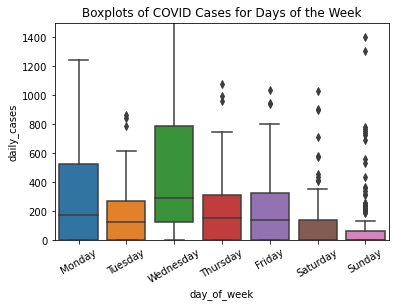

In [23]:
dow_viz = sns.boxplot(x=meck_cases_by_date['day_of_week'], y=meck_cases_by_date['daily_cases'])
dow_viz.set(title='Boxplots of COVID Cases for Days of the Week')
dow_viz.set_ylim(0,1500)
dow_viz.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=30)

The ranges of cases reported does seem to depend on the day of the week with Saturday and Sunday showing the lowest. As reported by [Dr. Lauren Hale](https://dearpandemic.org/covid-19-numbers-lower-on-the-weekends/#:~:text=Fewer%20patients%20get%20tested%20on,feeling%20symptoms%20on%20the%20weekend.), COVID cases reported are lower in the weekend due to less people getting tested and labs processing fewer tests on the weekend. Since this is not a real movement in COVID cases, it will be better to analyze COVID cases as a 7-day moving average where the decreases in weekend reporting will not impact only some dates. As for modeling for people delaying testing beyond averaging the daily cases over the week there is not more that can be done. There is no concrete system for knowing how people saught testing over the course of the pandemic.

In [40]:
# Make 7-day average column
meck_cases_by_date['moving_avg_cases'] = meck_cases_by_date['daily_cases'].rolling(7).mean()

Moving back to standardization for a bit, it will be difficult to compare counties to each other due to population differences. One way to account for that is to compare per capita, but as that total will be tiny I will evaluate new cases per 100,000 residents.

In [48]:
meck_cases_by_date['moving_avg_cases'] = (meck_cases_by_date['moving_avg_cases']*100000)/MECK_POP

In [49]:
# Getting the correct date range
meck_cases_by_date = meck_cases_by_date[(meck_cases_by_date['date']>=pd.Timestamp(2020,2,1)) &
                                        (meck_cases_by_date['date']<=pd.Timestamp(2021,10,1))]
meck_cases_by_date = meck_cases_by_date.set_index('date')

## 3. How should we consider the effect of the mask?

The [CDC recommends waiting at least five days after exposure to test for COVID](https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/testing.html). This is to ensure that the test does not provide an inaccurate result. With this in mind, masking will not immediately reduce positive cases of COVID. We shouldn't expect the slope to move downward until five days after the policy taking effect if masks do reduce the spread of COVID. This model will account for the effect of the mask by visualizing when mask mandates were in effect or not.

## 4. How to account for a change in slope over time?

One way to display when the changes in slope occur is to use the [ruptures](https://medium.com/dataman-in-ai/finding-the-change-points-in-a-time-series-95a308207012) package. Ruptures will detect when a change of slope occurs and can add these points to the visualization. Below the index is set to date so rupture's points are saved on the date and not the index. The change points in slope will be displayed in the visualization with vertical black lines.

In [50]:
data = np.array(meck_cases_by_date['moving_avg_cases'])
 
alg = rpt.Pelt(model='rbf').fit(data)
change_loc = alg.predict(pen=10)
change_loc = meck_cases_by_date.iloc[change_loc[:-1]].index.to_list()

## 5. How can we model different proportions of mask requirements compliance?

One way to describe the impact of masking utilizing the New York Times survey data on mask mandate compliance is to create a weight from the data according to the proportion of each response type. Multiply ALWAYS by 1, FREQUENTLY by .75, SOMETIMES .5, RARELY .25, and NEVER by 0. Then sum these values together. This weight will be <1 and can be divided by the coefficient for the mask mandate classification since the impact of masking would be greater than the observed impact due to the people not complying with it. Since I am not training a model in this moment it will not be included in the visualization.

In [45]:
meck_mask

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1949,37119,0.029,0.037,0.075,0.166,0.694


## 6. How to handle different masking policies?

It is true that policies varied in implementation over the course of the pandemic and that the CDC data displaying mask mandates shows the specific mandate being implemented. In the case of Mecklenburg, mask mandates were implemented due to 18 different state executive orders and one state department of health and human services directive. There may be a path to reading through the 19 different citations enforcing a mask mandate for Mecklenburg, categorize each one, and implement the categorizations into the model. The cost for doing this in the scope of the project is prohibitive and I will not be implementing differences in mandates into the model.

In [25]:
meck_mand['Citation'].unique()

array([nan, 'N.C. Exec. Order No. 147 (June 24, 2020)',
       'N.C. Exec. Order No. 151 (July 16, 2020)',
       'N.C. Exec. Order No. 155 (Aug. 5, 2020)',
       'N.C. Exec. Order No. 163 (Sept. 1, 2020)',
       'N.C. Exec. Order No. 169 (Sept. 30, 2020)',
       'N.C. Exec. Order No. 170 (Oct. 21, 2020)',
       'N.C. Exec. Order No. 176 (Nov. 10, 2020)',
       'N.C. Exec. Order No. 180 (Nov. 23, 2020)',
       'N.C. Exec. Order No. 181 (Dec. 8, 2020)',
       'N.C. Health Directive  (Jan. 6, 2021)',
       'N.C. Exec. Order No. 188 (Jan. 6, 2021)',
       'N.C. Exec. Order No. 189 (Jan. 27, 2021)',
       'N.C. Exec. Order No. 195 (Feb. 24, 2021)',
       'N.C. Exec. Order No. 204 (Mar. 23, 2021)',
       'N.C. Exec. Order No. 209 (Apr. 28, 2021)',
       'N.C. Exec. Order No. 215 (May 14, 2021)',
       'N.C. Exec. Order No. 220 (June 11, 2021)',
       'N.C. Exec. Order No. 224 (July 29, 2021)'], dtype=object)

## 7. My county did not implement a masking policy? What now?

Fortunately masking was mandatory in Mecklenburg due to state orders. This means it is an issue I do not have to face. However, if this was the case I would first consider if I could mark when masking was recommended and categorize those times as the voluntary masking periods. If that was not the case, I would find other counties in the region, and would consider the day a voluntary masking day if over half the counties had mandatory masking and a no mask day if otherwise.

## 8. How should we account for different vaccination rates in counties?

If we were to have the vaccination rates for the county by day then those rates could be included into the model as well. There would also be worth in evaluating if fully vaccinated rates or fully + partially vaccinated rates are better indicators in impacting new cases. As I cannot readily find this information to incorporate into my model I will not be implementing it.

# Visualization

In [51]:
meck_cases_by_date = meck_cases_by_date.reset_index()
meck_covid = meck_cases_by_date.merge(meck_mand, how='left', on='date')
meck_covid = meck_covid.set_index('date')

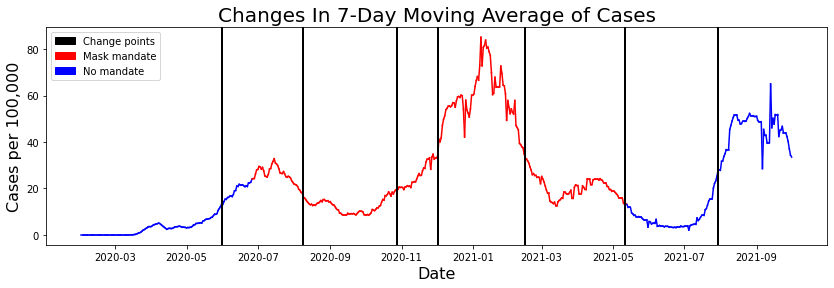

In [52]:
red_patch = mpatches.Patch(color='red', label='Mask mandate')
blue_patch = mpatches.Patch(color='blue', label='No mandate')
black_patch = mpatches.Patch(color='black', label='Change points')
plt.figure(figsize=(14,4))
for i in range(1,len(meck_covid)):
    s = meck_covid.iloc[i-1:i+1]
    color = 'r' if s['Face_Masks_Required_in_Public'].eq(1).all() else 'blue'
    plt.plot(s['moving_avg_cases'], c=color)
for x in change_loc:
    plt.axvline(x, lw = 2, color='black')
plt.legend(loc=2, ncol=1, handles=[black_patch, red_patch, blue_patch])
plt.title('Changes In 7-Day Moving Average of Cases', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cases per 100,000', fontsize=16)
plt.savefig('visualizations/change_points.png')